Available datasets:
	Wereflamingos_18May2023,
	Wereflamingo_X4_2May23,
	NoAlloPyramid_14Oct22,
	TypeDeplTests,
	Wereflamingo_X4_18Apr23,
	AlloPyramid_X3_17Nov22_13Mar23Suppl,
	Wereflamingo_X4_8May23,
	Wereflamingo_X2_18Apr23,
	AlloWerewolf_10_23,
	Cubes3x3,
	AlloPyramid_Reduced_29Oct22,
	AlloPyramid_14Oct22,
	Wereflamingo_X4_longsim_2023-06-20,
	Wereflamingo_X3_18Apr23,
	AlloPyramid_X3_17Nov22,
	Icosahedron_28Nov22,
	NoAlloPyramid_14Oct22_29OctSuppl,
	WerewolfNoAllo_10_23,
	TestTetramer28Feb23,
	AlloPyramid_14Oct22_29OctSuppl,
	Icosahedron,
	Wereflamingo_X3_2May23,
	Wereflamingo_X2_longsim_2023-06-20,
	Wereflamingo_X2_2May23


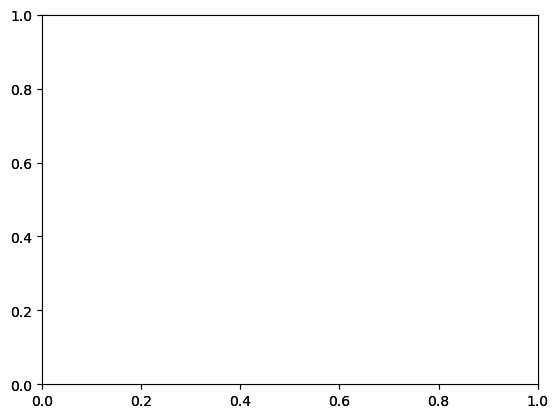

In [1]:
from pypatchy.patchy.analysis.input_output import *
from functools import reduce
import altair as alt
print("Available datasets:\n\t" + ',\n\t'.join(os.listdir(sims_root())))

In [2]:
# Edit this cell to specify which datasets to compare
dataset_names = ["WTSolidCube_Minimal_JB", "AlloSolidCube_X1_12Dec22", "AlloSolidCube_X3_Singlet_12Dec22", "AlloSolidCube_X5_1_12Dec22", "AlloSolidCube_X5_4_12Dec22"]
# dataset_names = ["WTHollowCube_7Nov22", "AlloHollowCubeMin_X1_9Nov22", "AlloHollowCube_X1_7Nov22"]
# dataset_names = ["Allosteric_Pyramid_Full_Fall22","AlloPyramid_X4_14Mar23", "NoAlloPyramid_14Oct22"]
### Readability ### 
# make sure the order is the same as dataset_names!!!!
# dataset_names_readable = ["X1", "X4", "Non-Allosteric"]
dataset_names_readable = ["WT", "X1", "X3 S", "X5 1", "X5 4"]
# group_name = "Pyramid"
group_name = "Solid Cube"

In [3]:
assert(len(dataset_names) > 0)
datasets = [choose_results(dsname) for dsname in dataset_names]

In [4]:
target_name_options = reduce(set.intersection, [set(r.targets.keys()) for r in datasets])
print(f"Target options {','.join(target_name_options)}")

Target options solidcube


In [5]:
target_name = "solidcube"
# target_name = "solidcube"

In [6]:
# construct a PatchySimResultSet object from the specified directory
targets = [r.targets[target_name] for r in datasets]

In [7]:
# PARAMETERS!!!!!
# narrow type = set of parameters specifying bonding angles between patches
# cutoff = the lower limit for counting clusters as partially assembled forms of the target
# cutoff = 1 -> only count fully assembled clusters
cutoff = 1
overreach = False
sample_every = 10

In [ ]:
datasets_data = []
for dataset, dsname in zip(datasets, dataset_names):
    print(f"Analyzing {dsname}")
    data = dataset.get_stats(target_name, cutoff, overreach=overreach, sample_every=sample_every, verbose=True)
    # data = dataset.get_flat_yields(target_name, cutoff, overreach=overreach)
    data['dsname'] = dsname
    datasets_data.append(data)
data = pd.concat(datasets_data, axis='index').reset_index()

Analyzing WTSolidCube_Minimal_JB
Computing yields of DEFAULT duplicate 0 nt=0 T=0.01 with target=solidcube, overreach=False, cutoff=1...



Please cite these publications for any work that uses the oxDNA simulation package
		- for the code:
			* P. Šulc et al., J. Chem. Phys. 137, 135101 (2012)
			* L. Rovigatti et al., J. Comput. Chem. 36, 1 (2015)
		- for the oxDNA model:
			* T. E. Ouldridge et al., J. Chem. Phys, 134, 085101 (2011)
		- for the oxDNA2 model:
			* B. E. K. Snodin et al., J. Chem. Phys. 142, 234901 (2015)
		- for the oxRNA model:
			* P. Šulc et al., J. Chem. Phys. 140, 235102 (2014)


Missing 20 timepoints... Categorizing...
Starting categorizing clusters DEFAULT duplicate 0 nt=0 T=0.01...
Missing timepoint at timepoint 10. Calculating...


In [ ]:
shortest_timeseries = min(itertools.chain.from_iterable([
    [r.num_timepoints() 
         for r in dataset.flat_runs()] 
    for dataset in datasets
]))
mintime = shortest_timeseries * OXDNA_PRINT_CLUSTERS_EVERY
data = data[data["time"] < mintime]

In [ ]:
print(f"Temperature options: {data['temp'].unique()}")

In [ ]:
### MORE PARAMETERS!!! ####
nt = 0
temperatures = [0.01, 0.025]
ymax = 8
relative=True

df = data[(data['nt'] == nt) & (data['temp'].isin(temperatures))]

shapes = ["DEFAULT"]

# assert(len(shapes) > 0)
# indexer = reduce(lambda a,b: (a | b), [df['shape'] == s for s in shapes])
# df = df[indexer]

# normalize yield if applicable, either way format x axis
if relative:
    df['yield_min'] = df['yield_min'] / ymax
    df['yield_max'] = df['yield_max'] / ymax
    # df['yield_stdev'] = df['yield_stdev'] / ymax
    df['yield'] =  df['yield'] / ymax
    ymax = 1.0
    x_axis_format = '.0%'
else:
    x_axis_format = '.00'
df['time'] /= 1e6 # convert steps to megasteps

charts = []
# if len(shapes) == 1:
#     chart_title = f"Comparison of Datasets: {', '.join(dataset_names_readable)} (Group: {shapes[0]}) (Narrow Type {nt})"
# else:
chart_title = f"Comparison of Datasets {group_name} {', '.join(dataset_names_readable)} (Narrow Type {nt})"
if len(target_name_options) > 1:
    chart_title += f"Analysis Target: {target_name}"
temperatures = df['temp'].unique()
for i, t in enumerate(temperatures):
    charts.append(alt.Chart(df[df['temp'] == t], title=f"T={t}"))
    charts[i] = charts[i].mark_line().encode(
        x=alt.X('time:Q', title="Time (megasteps)", axis=alt.Axis(tickCount=5)),
        y=alt.Y(
            "yield:Q",
            title="Yield",
            scale=alt.Scale(domain=(0,ymax)),
            axis=alt.Axis(format=x_axis_format, tickCount=4)
        ),
        color=alt.Color('dsname:O', scale=alt.Scale(scheme="accent"), title="Dataset")
    ) + charts[i].mark_area(opacity=0.25).encode(
        x=alt.X("time:Q", axis=alt.Axis(tickCount=5)),
        y="yield_min:Q",
        y2="yield_max:Q",
        color=alt.Color('dsname:O', scale=alt.Scale(scheme="accent"), title="Dataset")
    )
chart = alt.hconcat(*charts)
# ) + alt.Chart(df).mark_errorband(extent='ci', opacity=0.2).encode(
#     x=alt.X('time:Q'),
#     y=alt.Y('yield', title='Yield'), accept_partials=True
#     color = alt.Color('shape', scale=alt.Scale())
# )).properties(width=600, height=450).facet(column='potential', row='type').properties(title=sim_name)"None of the students learn anything and it's your fault"

chart = chart.properties(title=chart_title)
chart.configure_axis(
    labelFontSize=18,
    titleFontSize=20
).configure_title(fontSize=24)
# chart.save(sims_root() + os.sep + results.export_name + os.sep + results.export_name + ".html")

In [ ]:
data

In [ ]:
mintime